In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard


2023-12-09 09:13:34.090507: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# 读取位于指定路径的 CSV 文件并将其存储到 DataFrame 中
df_train = pd.read_csv("plant_dataset_org/train/train_label.csv")
# 对 DataFrame 的 "labels" 列应用 lambda 函数
# lambda 函数根据空格拆分 "labels" 列的值，并创建一个列表
df_train["labels"]=df_train["labels"].apply(lambda x:x.split(" ")) 



# 读取位于指定路径的 CSV 文件并将其存储到 DataFrame 中
df_val = pd.read_csv("plant_dataset_org/val/val_label.csv")
# 对 DataFrame 的 "labels" 列应用 lambda 函数
# lambda 函数根据空格拆分 "labels" 列的值，并创建一个列表
df_val["labels"]=df_val["labels"].apply(lambda x:x.split(" ")) 


# 指定包含训练图像和验证图像的目录路径
train_path='plant_dataset_org/train/images'
val_path = 'plant_dataset_org/val/images'

In [3]:
# 设置图像大小
img_size=(128,128)

# 创建图像数据生成器，用于数据增强
datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像进行归一化，将像素缩放到[0,1]区间
    zoom_range=0.2,  # 随机缩放图像的范围
    horizontal_flip=True # 随机水平翻转图像
)


# 通过图像数据生成器创建训练数据生成器
train_generator=datagen.flow_from_dataframe(
dataframe=df_train, # 从 DataFrame_train 作为训练数据
directory=train_path, # 图像文件所在的目录路径
x_col="images", # DataFrame 中包含图像文件名的列
y_col="labels", # DataFrame 中包含标签的列
batch_size=64,  # 批处理大小
seed=42,  # 随机种子，确保可重复性
shuffle=True, # 每个 epoch 后打乱数据
class_mode="categorical",  # 返回 one-hot 编码的标签，适用于多分类问题
target_size=img_size)  # 图像目标大小

# 通过图像数据生成器创建验证数据生成器
val_generator=datagen.flow_from_dataframe(
dataframe=df_val,  # 从 DataFrame_val作为验证数据
directory=val_path,
x_col="images",
y_col="labels",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=img_size)

print(train_generator.class_indices)
print(val_generator.class_indices)

Found 3000 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.
{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}
{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}


In [4]:
# 使用 InceptionV3 模型加载预训练权重，不包括顶层（全连接层），指定输入图像的形状为 (128, 128, 3)
model_pretrained = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(128,128,3))
# 创建序贯模型
model=keras.models.Sequential()

# 添加预训练的 InceptionV3 模型作为第一层
model.add(model_pretrained)

# 将模型展平为一维数组
model.add(keras.layers.Flatten())

# 添加全连接层，包含 300 个神经元，激活函数为 ReLU
model.add(keras.layers.Dense(300, activation="relu"))

# 添加 Dropout 层，防止过拟合，丢弃率为 20%
model.add(keras.layers.Dropout(0.2))

# 添加全连接层，包含 100 个神经元，激活函数为 ReLU
model.add(keras.layers.Dense(100,activation='relu'))

# 再次添加 Dropout 层，防止过拟合，丢弃率为 20%
model.add(keras.layers.Dropout(0.2))

# 添加输出层，包含 6 个神经元，使用 sigmoid 激活函数进行多标签分类
model.add(keras.layers.Dense(6,activation="sigmoid"))


2023-12-09 09:14:35.732538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 09:14:36.325421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10099 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:5e:00.0, compute capability: 8.6


In [5]:
# 打印模型的摘要信息
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 300)               2457900   
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 6

In [6]:
# 设置总训练轮数
epoch=100
# 设置初始学习率
learning_rate=0.01
# 计算学习率衰减的速率，即每个epoch衰减的学习率
decay_rate=learning_rate/epoch
# 设置动量参数
momentum=0.8
# 使用随机梯度下降SGD优化器，设置学习率、动量和学习率衰减
sgd=SGD(learning_rate=learning_rate,momentum=momentum,decay=decay_rate)

In [7]:
# Early stopping callback
# 创建EarlyStopping回调函数，用于在训练过程中根据验证集损失来提前停止训练
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [8]:
# 编译模型，设置损失函数，优化器和评估指标
model.compile(loss='binary_crossentropy', # 使用二分类交叉熵作为损失函数，适用于多标签分类问题
              optimizer='sgd', # 使用随机梯度下降（SGD）作为优化器
              metrics=[tf.keras.metrics.Precision()]) # 监测模型性能的评估指标，这里使用精确度（Precision）

In [9]:
# 使用模型进行训练，将训练数据生成器传递给模型
# 设置训练轮数（epochs）、验证数据生成器、是否打乱数据、以及提前停止的回调函数
model_history=model.fit(train_generator,epochs=epoch,validation_data=val_generator,shuffle=True, callbacks=[callback,TensorBoard(log_dir="Inc_TFboard",histogram_freq=0)])
# train_generator 训练数据生成器
# epochs 训练轮数
# validation_data 验证数据生成器
# shuffle 在每个epoch开始前是否打乱数据
# callbacks 提前停止的回调函数，用于根据验证集损失提前停止训练

# 在模型训练后保存整个模型
model.save("Inception_model.h5")
# # 关机
# os.system("shutdown")

Epoch 1/100


2023-12-09 09:16:11.728854: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 09:16:13.823617: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47/47 [==============================] - 196s 4s/step - loss: 0.5587 - precision: 0.1977 - val_loss: 0.5140 - val_precision: 0.2857
Epoch 2/100
47/47 [==============================] - 172s 4s/step - loss: 0.4877 - precision: 0.3129 - val_loss: 0.4595 - val_precision: 0.3333
Epoch 3/100
47/47 [==============================] - 174s 4s/step - loss: 0.4669 - precision: 0.3701 - val_loss: 0.4402 - val_precision: 0.5556
Epoch 4/100
47/47 [==============================] - 176s 4s/step - loss: 0.4507 - precision: 0.4061 - val_loss: 0.4298 - val_precision: 0.8000
Epoch 5/100
47/47 [==============================] - 174s 4s/step - loss: 0.4372 - precision: 0.4678 - val_loss: 0.4202 - val_precision: 0.7273
Epoch 6/100
47/47 [==============================] - 174s 4s/step - loss: 0.4221 - precision: 0.5265 - val_loss: 0.4057 - val_precision: 0.6757
Epoch 7/100
47/47 [==============================] - 173s 4s/step - loss: 0.4123 - precision: 0.5539 - val_loss: 0.4080 - val_precision: 0.7328
Epoc

In [10]:
# 加载整个模型
loaded_model = keras.models.load_model("Inception_model.h5")

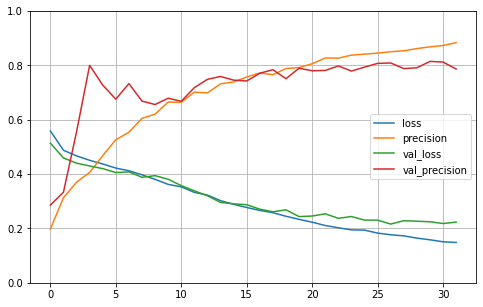

In [11]:
# 将模型训练的历史记录转换为 DataFrame，并绘制各种指标的曲线图
pd.DataFrame(model_history.history).plot(figsize=(8,5))

# 设置绘图区域的网格
plt.grid(True)

# 设置y轴的取值范围在0到1之间，以便更好地观察精确度等指标
plt.gca().set_ylim(0,1)

# 显示绘图
plt.show()

In [12]:
# 指定测试图像文件夹的路径
test_path = 'plant_dataset_org/test/images'
# 读取位于指定路径的 CSV 文件并将其存储到 DataFrame 中
df_test = pd.read_csv("plant_dataset_org/test/test_label.csv")
# 对 DataFrame 的 "labels" 列应用 lambda 函数
# lambda 函数根据空格拆分 "labels" 列的值，并创建一个列表
df_test["labels"]=df_test["labels"].apply(lambda x:x.split(" ")) 
# 通过图像数据生成器创建测试数据生成器

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,            # 包含图像文件名的 DataFrame
    directory=test_path,              # 测试图像文件夹的路径
    x_col="images",                    # DataFrame 中包含图像文件名的列
    y_col="labels",                    # 在测试阶段不需要标签
    batch_size=1,                     # 批处理大小为1，因为每个测试样本都是单独的批次
    seed=42,                          # 随机种子，确保可重复性
    shuffle=False,                     # 每次生成数据时是否打乱数据
    class_mode="categorical",         # 在测试阶段需要类别信息
    target_size=img_size              # 图像目标大小
)



Found 600 validated image filenames belonging to 6 classes.


In [13]:
# 在测试集上评估模型
evaluation = loaded_model.evaluate(test_generator, steps=test_generator.samples // 1)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

600/600 [==============================] - 36s 58ms/step - loss: 0.2505 - precision: 0.7504
Test Accuracy: 75.04%


311
1/1 [==============================] - 0s 174ms/step


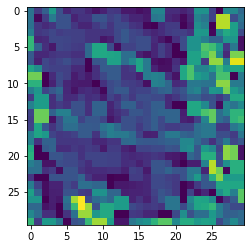

In [14]:
print(len(model_pretrained.layers))
layer_index = 10  # 选择InceptionV3中的某个卷积层

# 提取指定卷积层的输出
intermediate_layer_model = Model(inputs=model_pretrained.input,
                                 outputs=model_pretrained.layers[layer_index].output)

# 加载一张图片进行测试
img_path = '803e3bd17a16e65c.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 获取卷积层的输出
intermediate_output = intermediate_layer_model.predict(img_array)

# 可视化特征图
plt.imshow(intermediate_output[0, :, :, 0], cmap='viridis')  # 选择通道进行可视化
plt.show()

600/600 [==============================] - 34s 55ms/step


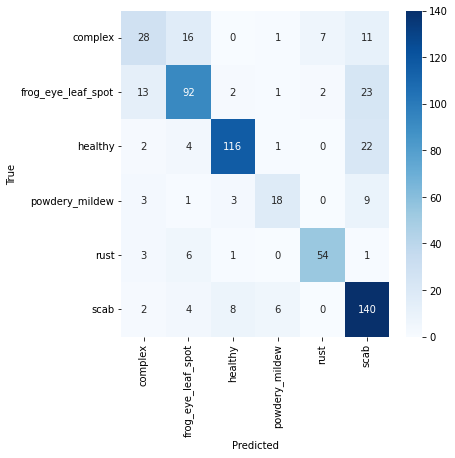

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 获取测试集的真实标签
true_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
# print(true_labels)
# 获取模型在测试集上的预测标签
predicted_labels = model.predict(test_generator, steps=len(test_generator))
# 将标签从 one-hot 编码转换为类别
true_classes = np.argmax(true_labels, axis=1)
predicted_classes = np.argmax(predicted_labels, axis=1)

# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 可视化混淆矩阵
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
# 保存混淆矩阵到文件
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
# # 关机
# os.system("shutdown")